In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import gurobipy as gp 
from gurobipy import GRB
import os

np.random.seed(2023)

In [6]:
# generate positive semi-definite matrix
def gen_psd(n):
    X = np.random.rand(n, n)
    B = np.dot(X, X.transpose())
    B_pos = B - np.linalg.eigvalsh(B).min() * np.eye(n)
    X_pos = np.sqrt(B_pos)
    return X_pos

def generate_A_matrix(n):
    # 创建基本矩阵块
    I_n = np.eye(n)        # n×n 单位矩阵
    zero_block = np.zeros((n, n))  # n×n 零矩阵
    
    # 创建每一行块
    row1 = np.hstack([I_n, -I_n, I_n])      # 第一行: [I_n, -I_n, I_n]
    row2 = np.hstack([zero_block, -I_n, zero_block])  # 第二行: [0, -I_n, 0]
    row3 = np.hstack([zero_block, zero_block, -I_n])  # 第三行: [0, 0, -I_n]
    
    # 垂直堆叠所有行块
    block_matrix = np.vstack([row1, row2, row3])
    
    return block_matrix

def hat_f(x, X, b):
    return np.linalg.norm(X@x-b, 2)**2/2.0

def grad_hat_f(x, X, b):
    return X.T@(X@x-b)

def f(x, X, b, lambd, n):
    hat_x = x[:n]
    bar_x = x[n:]
    return np.linalg.norm(X@hat_x-b, 2)**2/2.0+lambd * np.ones(2*n)@bar_x

def grad_f(x, X, b, lambd, n):
    hat_x = x[:n]
    bar_x = x[n:]
    hat_grad = X.T@(X@hat_x-b)
    bar_grad = lambd * np.ones(2*n)
    return np.concatenate([hat_grad, bar_grad], axis=0) 

In [7]:
import pickle

with open('../Result/results_2025-08-27_17_07_parameters.pkl', 'rb') as file:
    loaded_object = pickle.load(file)


# Storage = {'result':res,'rho': rho, 'alpha': alpha, 'lambd': lambd,'X_matrix': X, 'time': time, 'step': step, 'time_step': time_eval, 'n': n, 'x_opt': x_opt, 'y_opt': y_opt, 'l':lf}

res = loaded_object['result']
X = loaded_object['X_matrix']
time = loaded_object['time']
step = loaded_object['step']
n = loaded_object['n']
lf = loaded_object['l']
alpha = loaded_object['alpha']
lambd = loaded_object['lambd']
rho = loaded_object['rho']

m = n
In = np.eye(n)
Im = np.eye(m)
Bdim = 3*n
dim = 6*n
time_eval = np.linspace(0,time,step)

try:
    os.makedirs('Para', exist_ok=True)
    
    b = np.load('../Para/vector_b.npy')
    w0 = np.load('../Para/vector_x0.npy')
    
except FileNotFoundError:
    print("Error:Not Find Parameters")

In [8]:
A = generate_A_matrix(n)
large_sigma_A = np.max(np.linalg.eigvals(A @ A.T))
small_sigma_A = np.min(np.linalg.eigvals(A @ A.T))      

lf = np.linalg.eigvalsh(np.dot(X, X.transpose())).max()
mf = np.linalg.eigvalsh(np.dot(X, X.transpose())).min()

B = np.eye(3*n)
large_sigma_B = np.max(np.linalg.eigvals(B @ B.T))
small_sigma_B = np.min(np.linalg.eigvals(B @ B.T))

print(large_sigma_A,small_sigma_A,large_sigma_B,small_sigma_B, lf, mf, b, w0)

3.7320508075688767 0.2679491924311225 1.0 1.0 16.491425542730166 1.6238684845724173e-05 [-1.10766342 -1.94602338 -1.48254958 -2.20816044 -0.49962592] [0.79162115 0.8103383  0.98055723 0.88478525 0.10980113 0.81971076
 0.30761289 0.26149467 0.40572354 0.55342038 0.62552644 0.07876025
 0.97228343 0.41131105 0.7216644  0.66328748 0.21822526 0.18717254
 0.72977924 0.86331326 0.39172036 0.11004811 0.9127915  0.35700599
 0.41296218 0.18354969 0.58599027 0.85567085 0.78968122 0.08784242]


In [9]:

# compute the optimal solution to the equivalent form of Lasso regression problem
def gurobi_lasso(X, b, lambd):
    dim = 3*n
    model = gp.Model("gp")
    model.setParam('OutputFlag', 0) 
    u = model.addMVar(dim, lb=-gp.GRB.INFINITY, name='u')


    x = u[:n]
    z = u[n:]
    obj = 0.5 * ((X@x-b)@(X@x-b)).sum() + lambd*np.ones(2*n)@z
    # set objective
    model.setObjective(obj, GRB.MINIMIZE)
    # set constraints
    I = np.eye(n)
    # B = np.block([-I, I])
    model.addConstr(x - u[n:2*n] + u[2*n:3*n] == 0)
    model.addConstr(u[n:] >= 0)

    model.update()
    model.optimize()

    u_opt = np.zeros(dim)
    v_opt = np.zeros(dim)
    if model.status == GRB.OPTIMAL:
        # Access the optimal variable values
        for i in range(dim):
            u_opt[i] = model.getVarByName('u[{}]'.format(i)).X
    else:
        print("Optimization did not converge to an optimal solution.")
    flag = 0
    for con in model.getConstrs():
        v_opt[flag] = con.Pi
        flag += 1
    v_opt[:n] = -v_opt[:n]
    return model.objVal, u_opt, v_opt

In [10]:
# draw
solution =res[-1]
u_opt = solution[:3*n]
v_opt = solution[3*n:]
x = u_opt - alpha * A.T @ np.linalg.inv(B) @ v_opt
y = np.linalg.inv(B) @ v_opt
print("u_opt: ", u_opt, "\n", "v_opt: ", v_opt)
# Double check 
# Compute the optimal value
f_opt, x_opt, y_opt= gurobi_lasso(X, b, lambd)
print('x:',x)
print('y:',y)
print('x_opt:',x_opt)
print('y_opt:',y_opt)
print("f(x): ", f(x, X, b, lambd, n))
print("f_opt: ", f(x_opt, X, b, lambd, n))

u_opt:  [-0.95998664 -1.5599828  -0.88213224 -0.69510522 -0.83622144 -0.97020115
 -0.97020115 -0.97020115 -0.97020115 -0.97020115 -0.97020098 -0.3804195
 -0.97020115 -0.97020115 -0.97020115] 
 v_opt:  [-3.95788637e+00 -4.00000000e+00 -3.63690453e+00 -2.86581899e+00
 -3.44762092e+00  7.95788637e+00  8.00000000e+00  7.63690453e+00
  6.86581899e+00  7.44762092e+00  4.21136309e-02  4.73656478e-11
  3.63095467e-01  1.13418101e+00  5.52379077e-01]
Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-19


x: [-1.67174970e-07 -5.89781649e-01 -7.33273442e-11 -2.04691819e-11
 -4.67829109e-11  3.59257069e-12  3.51851881e-12  3.72901710e-12
  4.12536671e-12  3.81517040e-12  1.67178645e-07  5.89781649e-01
  7.71116504e-11  2.46259679e-11  5.06409359e-11]
y: [-3.95788637e+00 -4.00000000e+00 -3.63690453e+00 -2.86581899e+00
 -3.44762092e+00  7.95788637e+00  8.00000000e+00  7.63690453e+00
  6.86581899e+00  7.44762092e+00  4.21136309e-02  4.73656478e-11
  3.63095467e-01  1.13418101e+00  5.52379077e-01]
x_opt: [-1.33222263e-08 -5.89781799e-01 -1.81683887e-10 -4.93052866e-11
 -2.94735926e-12  8.75699343e-12  8.80390538e-12  9.15768372e-12
  1.01660355e-11  9.42883653e-12  1.33309863e-08  5.89781799e-01
  1.90840655e-10  5.94721713e-11  1.23761945e-11]
y_opt: [-3.95788639 -4.         -3.63690455 -2.865819   -3.44762093  7.95788639
  8.          7.63690455  6.865819    7.44762093  0.04211361  0.
  0.36309545  1.134181    0.55237907]
f(x):  5.460607183129879
f_opt:  5.4606071769177404


# Proximal

In [11]:
# Compute the intermediate variable x_star
def cal_x_star(A, b, X, u, y, rho):
    model = gp.Model('qp')
    # 服务器专用设置
    model.setParam('OutputFlag', 0)
    model.Params.Threads = 0      # 使用所有可用核心

    p = model.addMVar(3*n, lb=-GRB.INFINITY, name='p')
    u_hat = p[:n]
    u_bar = p[n:]
    obj = 0.5 * ((X@u_hat-b)@(X@u_hat-b)).sum() + lambd*np.ones(2*n)@u_bar+y@A@p + rho/2.0*(p-u)@(p-u)
    
    # Add the scalar f_val to the Gurobi expression
    model.setObjective(obj, GRB.MINIMIZE)
    model.optimize()

    x_opt = p.x
    # print('u:',u,"x_opt: ", x_opt)

    # ## Check the optimality condition
    return x_opt

    # dynamics
'''
'''
def dynamic_prox(x, t, rho):
    u,y = x[:3*n],x[3*n:]
    x_star = cal_x_star(A, b, X, u, y, rho)
    du = rho*(x_star-u)
    dy = A@x_star

    # \bar_y should be non-positive
    for i in range(2*n):
        if y[n+i] <= 0:
            dy[n+i] = max(0, dy[n+i])
    dynamics = np.concatenate((du, dy)).reshape(3*(m+n)).tolist()
    # print("du:",du,'dy:',dy)
    return dynamics


# results
t = np.linspace(0,time,step)
rho_prox = rho
res_prox = []
res_prox = odeint(dynamic_prox, w0, t, args=(rho_prox,))

# Preconditioned Algorithm

In [12]:
def dynamic_preconditioned(x, t, alpha):
    u,y = x[:3*n],x[3*n:]
    x = u-alpha*A.T@y
    hat_x = x[:n]
    bar_x = x[n:]

    du = -grad_f(hat_x, X, b, lambd, n)-A.T@y
    dy = -alpha*A@grad_f(hat_x, X, b, lambd, n)+A@u-2*alpha*A@A.T@y
    
    # \bar_y should be non-positive
    for i in range(2*n):
        if y[n+i] <= 0:
            dy[n+i] = max(0, dy[n+i])
    dynamics = np.concatenate((du, dy)).reshape(3*(m+n)).tolist()
    return dynamics


# results
# initial condition
alpha_pre = alpha
res_pre = []
res_pre = odeint(dynamic_preconditioned, w0, t, args=(alpha_pre,))


# Draw

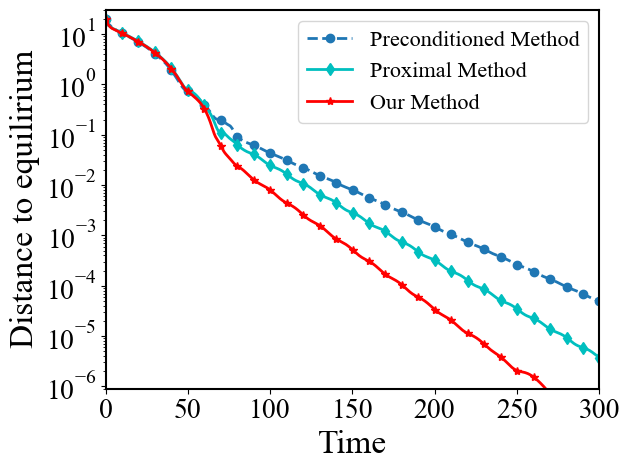

In [14]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure()
u_opt = x_opt + alpha*A.T@y_opt
v_opt = B@y_opt 

z_opt = np.concatenate((x_opt, y_opt)).reshape(1, 3*(n+m))
w_opt = np.concatenate((u_opt, v_opt)).reshape(1,3*(m+n))
# estimate = np.linalg.norm(w0 - w_opt, axis=1)*np.exp(-c*t)

plt.plot(t, np.linalg.norm(res_pre - w_opt, axis=1), 'o--', label='Preconditioned Method',markevery=n*5,linewidth=2.0)
plt.plot(t, np.linalg.norm(res_prox - z_opt, axis=1), 'cd-', label='Proximal Method', markevery=n*5,linewidth=2.0)
# plt.plot(t, cvx, '--', markevery=40, label='Strong Convexity '+r'$m_f$')
# plt.plot(t, estimate, ':', markevery=40, label='Our Estimate Rate')
plt.plot(t, np.linalg.norm(res-w_opt, axis=1), 'r*-', label='Our Method',markevery=n*5,linewidth=2.0)

plt.yscale("log")
plt.margins(x=0)
plt.xlabel('Time', font={'family':'Times New Roman', 'size':24})
plt.ylabel('Distance to equilirium', font={'family':'Times New Roman', 'size':24})
# legend = [r'$\Vert w-w_\star\Vert$', r'Estimate rate']
# legend = [r'$\Vert w-w_\star\Vert$', r'Estimate rate', r'Strong convexity $m_f$']
plt.legend( prop={'family':'Times New Roman', 'size':16})
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
# plt.title(r'Error ($\alpha={:.2f}/l$)'.format(alpha*1.4109146328560862), font={'family':'Times New Roman', 'size':16})
#设置图框线粗细
plt.ylim(1e-6-1e-7, 1e+1+20)
# 添加x轴范围限制
plt.xlim(0, 300)  
bwith = 1.5
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)

plt.tight_layout() 
plt.savefig('../Fig/method_comparison.pdf',dpi=1200)
plt.show()